<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

plt.rcParams["figure.figsize"] = (15,10)

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.sort_index(inplace=True)
resampled_daily = data.copy()
resampled_daily = resampled_daily.resample('1D').sum()
data = data.resample('1H').sum()

        Данные выгружены в переменную data. Произведено ресемплирование по одному часу и по одному дню.

## Анализ

In [5]:
data['rolling_mean'] = data['num_orders'].rolling(10).mean()
data['std'] = data['num_orders'].rolling(10).std()

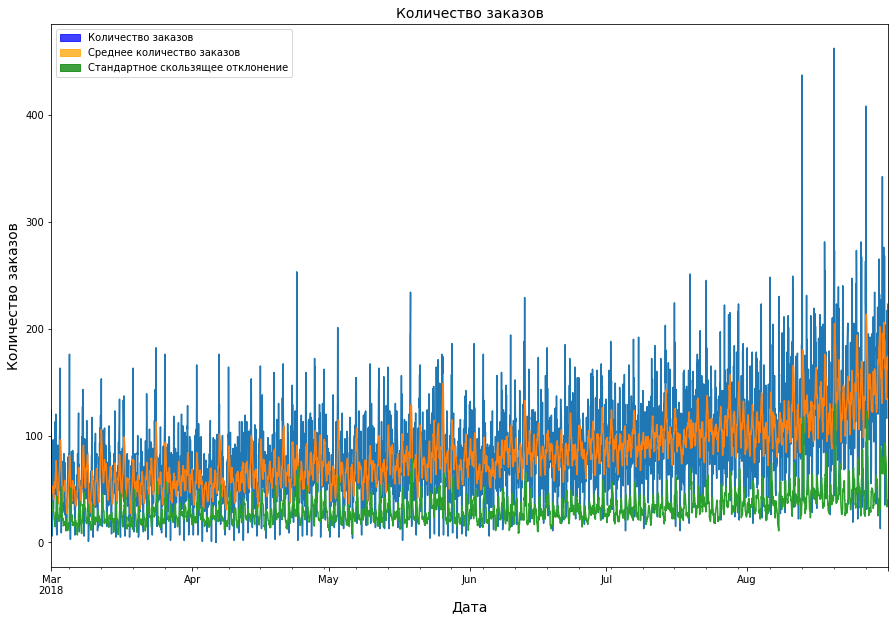

In [6]:
data.plot()
plt.title('Количество заказов', size=14)
plt.ylabel('Количество заказов', size=14)
plt.xlabel('Дата', size=14)
colors = {'Количество заказов':'blue', 'Среднее количество заказов':'orange', 'Стандартное скользящее отклонение':'green'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label], alpha=0.75) for label in labels]
plt.legend(handles, labels);

        В течении всего времени количество заказов растет.

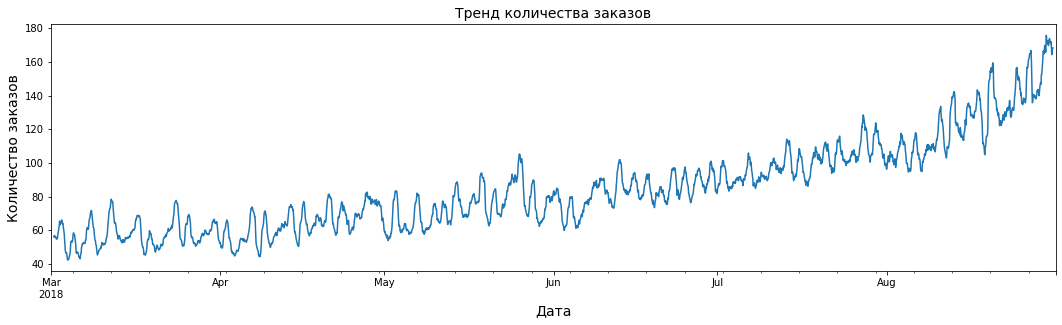

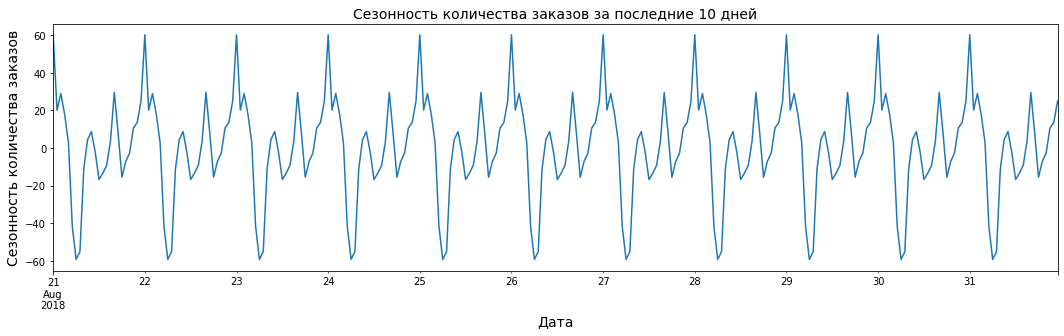

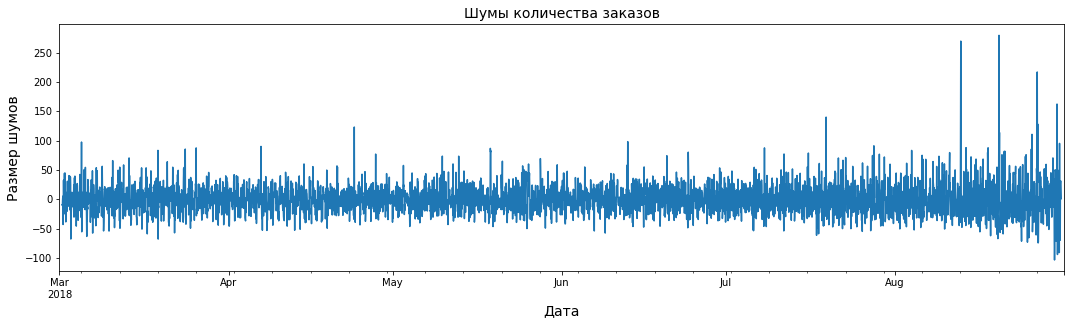

In [7]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(18, 10))
plt.subplot(2, 1, 1)
plt.title('Тренд количества заказов', size=14)
decomposed.trend.plot()
plt.ylabel('Количество заказов', size=14)
plt.xlabel('Дата', size=14)

plt.figure(figsize=(18, 10))
plt.subplot(2, 1, 2)
plt.title('Сезонность количества заказов за последние 10 дней', size=14)
decomposed.seasonal['2018-08-21':'2018-08-31'].plot()
plt.xlabel('Дата', size=14)
plt.ylabel('Сезонность количества заказов', size=14)

plt.figure(figsize=(18, 10))
plt.subplot(2, 1, 2)
plt.title('Шумы количества заказов', size=14)
decomposed.resid.plot()
plt.xlabel('Дата', size=14)
plt.ylabel('Размер шумов', size=14);

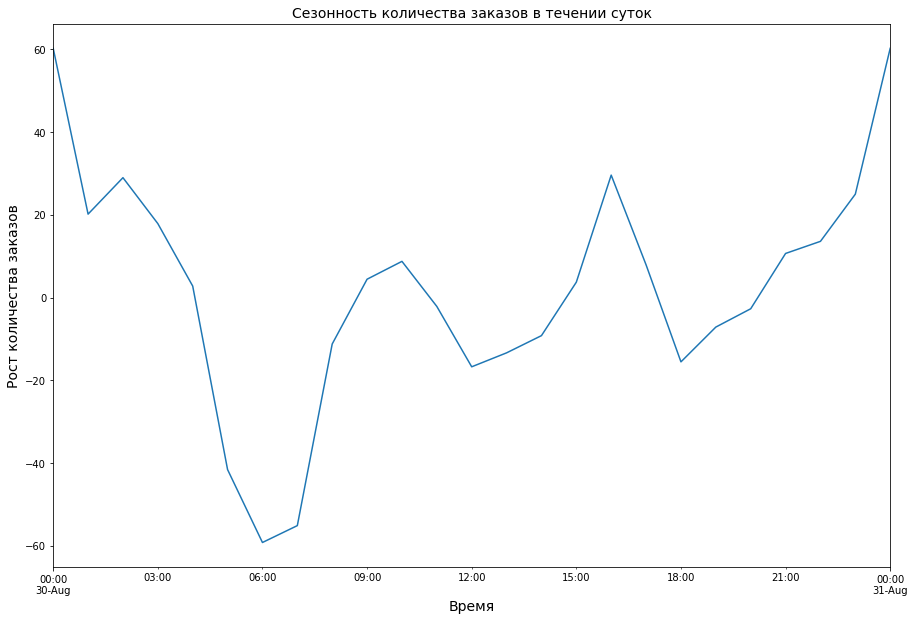

In [8]:
decomposed.seasonal['2018-08-30 00:00:00':'2018-08-31 00:00:00'].plot()
plt.title('Сезонность количества заказов в течении суток', size=14)
plt.xlabel('Время', size=14)
plt.ylabel('Рост количества заказов', size=14);

In [9]:
data_shift = pd.DataFrame(data['num_orders'] - data['num_orders'].shift())
data_shift['mean'] = data_shift['num_orders'].rolling(10).mean()
data_shift['std'] = data_shift['num_orders'].rolling(10).std()

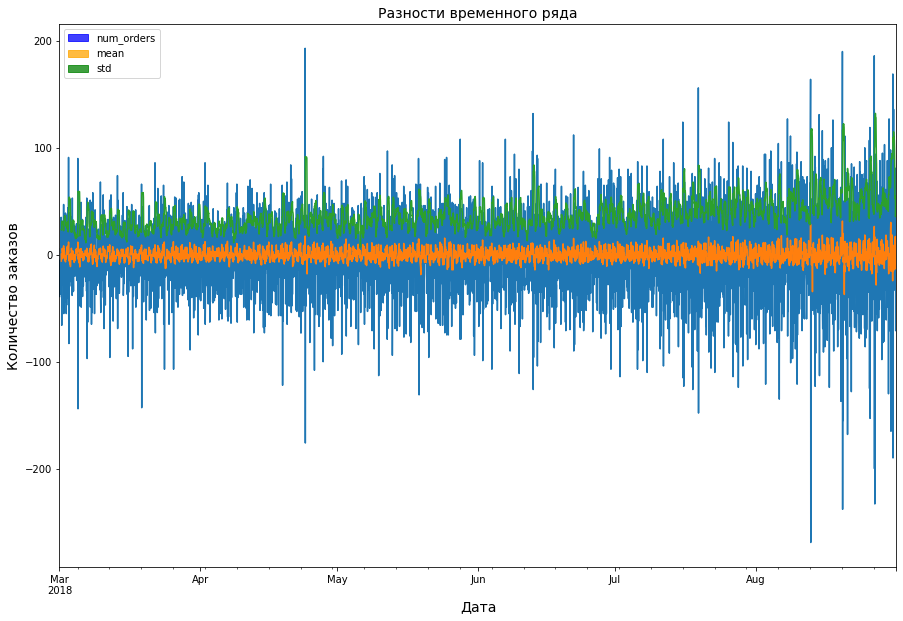

In [10]:
data_shift.plot()
plt.title('Разности временного ряда', size=14)
plt.ylabel('Количество заказов', size=14)
plt.xlabel('Дата', size=14)
colors = {'num_orders':'blue', 'mean':'orange', 'std':'green'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label], alpha=0.75) for label in labels]
plt.legend(handles, labels);

In [11]:
resampled_daily['rolling_mean'] = resampled_daily['num_orders'].rolling(10).mean()
resampled_daily['std'] = resampled_daily['num_orders'].rolling(10).std()

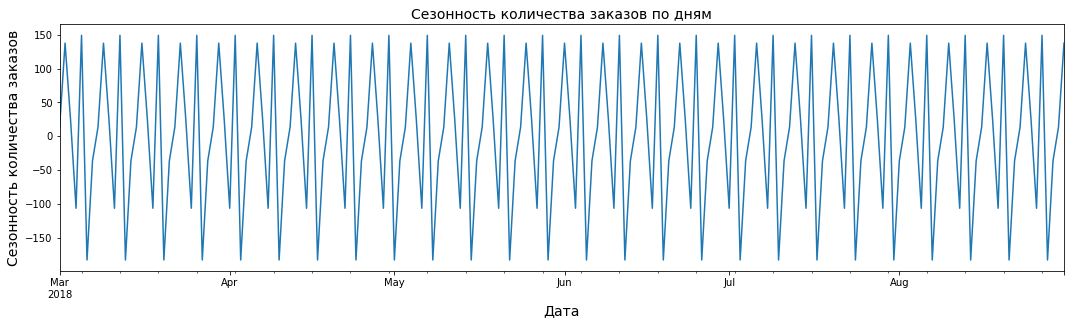

In [12]:
daily_decomposed = seasonal_decompose(resampled_daily['num_orders'])

plt.figure(figsize=(18, 10))
plt.subplot(2, 1, 2)
plt.title('Сезонность количества заказов по дням', size=14)
daily_decomposed.seasonal.plot()
plt.xlabel('Дата', size=14)
plt.ylabel('Сезонность количества заказов', size=14);

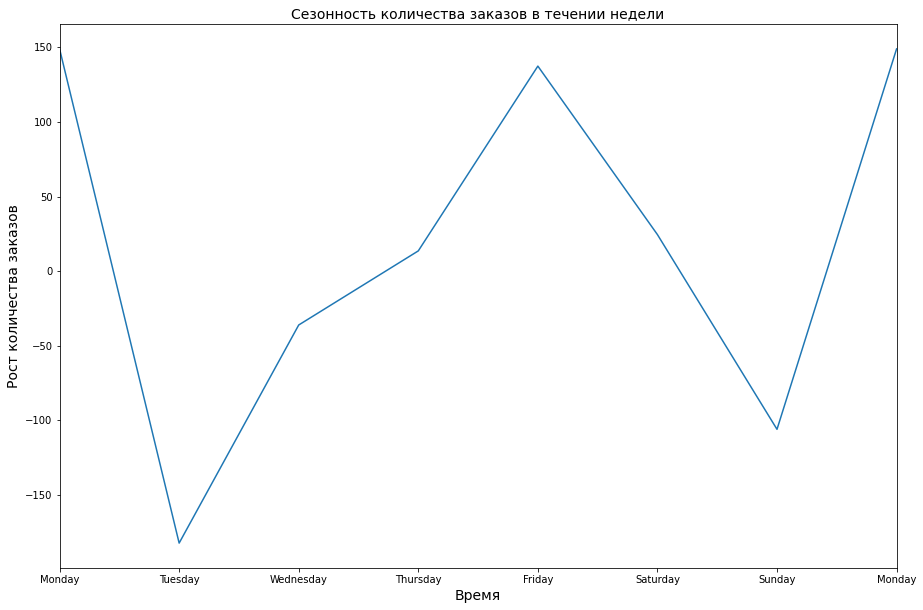

In [13]:
daily_decomposed.seasonal['2018-08-20':'2018-08-27'].plot()
plt.xticks(ticks=daily_decomposed.seasonal['2018-08-20':'2018-08-27'].index, 
           labels=daily_decomposed.seasonal['2018-08-20':'2018-08-27'].index.day_name())
plt.title('Сезонность количества заказов в течении недели', size=14)
plt.xlabel('Время', size=14)
plt.ylabel('Рост количества заказов', size=14);

        Проанализировано количество заказов, среднее количество заказов и стандартное скользящее отклонение. Изучен тренд 
     количества заказов, построен график, по которому видно, что в течении всего времени количество заказов растет. 
     Также изучена сезонность количества заказов за последние 10 дней. График показывает ежедневную цикличность. Изучена 
     сезонность в течении дня: самое большое количество заказов с 22:00 до 3:00, а также в 17:00, меньше всего заказов в 
     период с 5:00 до 7:00. Изучены шумы на всем промежутке данных, к концу графика доля остатков возрастает, поэтому
     возможно будет заметна разницы между метриками при обучении и тестировании. Изучена сезонность количество заказов при
     ресемплировании данных по одному дню. Заметна цикличность: большего заказов в понедельник и пятницу, меньше всего во
     вторник и в воскресенье.

## Обучение

In [14]:
data = data.drop(['std', 'rolling_mean'], axis=1)

In [15]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [16]:
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

for lag in range(1, 175):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(175)

data['rolling_mean'] = data['num_orders'].shift().rolling(50).mean()
data = data.dropna()

In [17]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=(1/9), shuffle=False, random_state=12345)

print('Размеры и размерности выборок:', features_train.shape, features_valid.shape, features_test.shape)

Размеры и размерности выборок: (3392, 178) (424, 178) (425, 178)


In [18]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)

predict = model.predict(features_valid)
rmse = mean_squared_error(target_valid, predict)**0.5

print(f'Значение RMSE для модели LinearRegression: {rmse:.1f}')

Значение RMSE для модели LinearRegression: 46.1
CPU times: user 437 ms, sys: 1.12 s, total: 1.56 s
Wall time: 1.54 s


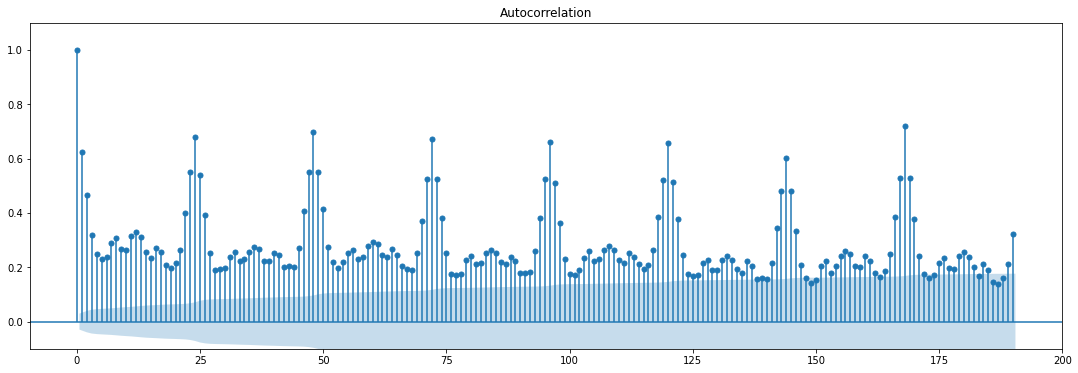

In [19]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


In [20]:
%%time
best_rmse = 150
for depth in [None] + [i for i in range(2, 7)]:
    for iterations in range(300, 500, 50):
        model = CatBoostRegressor(depth=depth, learning_rate=0.2, iterations=iterations, silent=True, random_state=12345)
        model.fit(features_train, target_train)
        predict = model.predict(features_test)
        rmse = mean_squared_error(target_test, predict)**0.5
        if rmse <= best_rmse:
            best_depth = depth
            best_iterations = iterations
            best_rmse = rmse
        print(f'Глубина: {depth} Количество итераций: {iterations} Значение RMSE: {rmse:.1f}')
print(f'Лучшая глубина: {best_depth} Лучшее количество итераций: {best_iterations} Лучшее значение RMSE: {best_rmse:.1f}')

Глубина: None Количество итераций: 300 Значение RMSE: 56.9
Глубина: None Количество итераций: 350 Значение RMSE: 56.6
Глубина: None Количество итераций: 400 Значение RMSE: 56.6
Глубина: None Количество итераций: 450 Значение RMSE: 56.8
Глубина: 2 Количество итераций: 300 Значение RMSE: 58.7
Глубина: 2 Количество итераций: 350 Значение RMSE: 59.8
Глубина: 2 Количество итераций: 400 Значение RMSE: 60.1
Глубина: 2 Количество итераций: 450 Значение RMSE: 59.8
Глубина: 3 Количество итераций: 300 Значение RMSE: 60.7
Глубина: 3 Количество итераций: 350 Значение RMSE: 60.3
Глубина: 3 Количество итераций: 400 Значение RMSE: 60.9
Глубина: 3 Количество итераций: 450 Значение RMSE: 60.3
Глубина: 4 Количество итераций: 300 Значение RMSE: 59.0
Глубина: 4 Количество итераций: 350 Значение RMSE: 58.4
Глубина: 4 Количество итераций: 400 Значение RMSE: 59.1
Глубина: 4 Количество итераций: 450 Значение RMSE: 58.9
Глубина: 5 Количество итераций: 300 Значение RMSE: 59.0
Глубина: 5 Количество итераций: 350 

In [21]:
%%time
best_rmse = 150
for depth in [None] + [i for i in range(2, 7)]:
    for est in range(40, 70, 10):
        model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predict = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, predict)**0.5
        if rmse < best_rmse:
            best_depth = depth
            best_est = est
            best_rmse = rmse
        print(f'Глубина: {depth} Количество деревьев: {est} Значение RMSE: {rmse:.1f}')
print(f'Лучшая глубина: {best_depth} Лучшее количество деревьев: {best_est} Лучшее значение RMSE: {best_rmse:.1f}')

Глубина: None Количество деревьев: 40 Значение RMSE: 34.9
Глубина: None Количество деревьев: 50 Значение RMSE: 35.1
Глубина: None Количество деревьев: 60 Значение RMSE: 35.0
Глубина: 2 Количество деревьев: 40 Значение RMSE: 46.2
Глубина: 2 Количество деревьев: 50 Значение RMSE: 46.2
Глубина: 2 Количество деревьев: 60 Значение RMSE: 46.3
Глубина: 3 Количество деревьев: 40 Значение RMSE: 41.8
Глубина: 3 Количество деревьев: 50 Значение RMSE: 41.8
Глубина: 3 Количество деревьев: 60 Значение RMSE: 42.0
Глубина: 4 Количество деревьев: 40 Значение RMSE: 37.9
Глубина: 4 Количество деревьев: 50 Значение RMSE: 38.0
Глубина: 4 Количество деревьев: 60 Значение RMSE: 38.2
Глубина: 5 Количество деревьев: 40 Значение RMSE: 36.8
Глубина: 5 Количество деревьев: 50 Значение RMSE: 36.7
Глубина: 5 Количество деревьев: 60 Значение RMSE: 36.8
Глубина: 6 Количество деревьев: 40 Значение RMSE: 36.4
Глубина: 6 Количество деревьев: 50 Значение RMSE: 36.3
Глубина: 6 Количество деревьев: 60 Значение RMSE: 36.4
Л

        В данные добавлены столбцы 'day', 'dayofweek' и 'hour'. Также были добавлены отстающие и скользящее значения.
     Данные были разделены на 3 выборки: тренировочную, валидационную и тестовую, в соотношении 8:1:1 соответственно.
     После создания признаков, было изучено 3 модели: LinearRegressor, CatBoostRegressor и RandomForestRegressor, 
     для моделей найдены лучшие параметры. Наилучший результат дала модель RandomForestRegressor. Лучшее значение RMSE на
     валидационной выборке равно 34,9. RandomForestRegressor необходимо протестировать на тестовой выборке.

## Тестирование

In [22]:
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])

In [23]:
%%time
model = RandomForestRegressor(n_estimators=40, max_depth=None, random_state=12345)
model.fit(features_train, target_train)


predict = model.predict(features_test)
rmse = mean_squared_error(target_test, predict)**0.5
print(f'Значение RMSE для модели LinearRegression: {rmse:.1f}')

Значение RMSE для модели LinearRegression: 46.1
CPU times: user 7.42 s, sys: 43.9 ms, total: 7.46 s
Wall time: 7.47 s


In [24]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
rmse = mean_squared_error(target_test, pred_previous)**0.5
print(f'Значение RMSE для константной модели: {rmse:.1f}')

Значение RMSE для константной модели: 58.8


        Тренировочная и валидационная выборки были объединены. Модель RandomForestRegressor обучена и проверена на тестовой
     выборке, значение RMSE = 46,1. Была проведена проверка на адекватность с помощью константной модели, результат которой
     равен 58,8. 

# Вывод
## Подготовка
    
    - Данные выгружены в переменную data;
    - Произведено ресемплирование по одному часу и по одному дню.
## Анализ

    - Проанализировано количество заказов, среднее количество заказов и стандартное скользящее отклонение;
    - Изучен тренд количества заказов, построен график, по которому видно, что в течении всего
    времени количество заказов растет;
    - Также изучена сезонность количества заказов. График показывает ежедневную цикличность;
    - Изучена сезонность в течении дня: самое большое количество заказов с 22:00 до 3:00, а также в 17:00, меньше всего 
    заказов в период с 5:00 до 7:00;
    - Изучены шумы на всем промежутке данных, к концу графика доля остатков возрастает, поэтому
     возможно будет заметна разницы между метриками при обучении и тестировании;
     - Изучена сезонность количество заказов при ресемплировании данных по одному дню;
     - Заметна цикличность: большего заказов в понедельник и пятницу, меньше всего во вторник и в воскресенье.
     
## Обучение

    - В данные добавлены столбцы 'day', 'dayofweek' и 'hour';
    - Добавлены отстающие и скользящее значения.
    - Данные были разделены на 3 выборки: тренировочную, валидационную и тестовую, в соотношении 8:1:1 соответственно;
    - После создания признаков, было изучено 3 модели: LinearRegressor, CatBoostRegressor и RandomForestRegressor, 
     для моделей найдены лучшие параметры;
     - Наилучший результат дала модель RandomForestRegressor. Лучшее значение RMSE на
     валидационной выборке равно 34,9.

## Тестирование

    - Тренировочная и валидационная выборки были объединены;
    - Модель RandomForestRegressor обучена и проверена на тестовой выборке, значение RMSE = 46,1;
    - Была проведена проверка на адекватность с помощью константной модели, результат которой равен 58,8;